In [140]:
import numpy as np
import dill
import importlib
import sys
import os
import matplotlib.pyplot as plt
import numba as nb
import random
'''
Placing subject mean decision times into the simulation function and then spitting out how many wins, indecisions, incorrects are predicted by it

Making sure the simulation accurately represents reality
'''

'\nPlacing subject mean decision times into the simulation function and then spitting out how many wins, indecisions, incorrects are predicted by it\n'

In [141]:
from plot_functions import *
from Subject_Object import *
sys.path.insert(0, r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Modeling Scripts\\') 
import Optimal_Stopping_Object_v2
importlib.reload(Optimal_Stopping_Object_v2) # Reloads so I don't have to restart kernel if I change a function in the Object of another py file
from Optimal_Stopping_Object_v2 import *

# SImulation Function 

In [142]:
@nb.njit
def simulation_runs(NUM_TRIALS, TRIAL_TIME, m, player_decision_times, agent_decision_times, 
                    decision_to_action_delay, reaction_times, movement_times, AGENT_MOVEMENT_TIME):
    if True: # Initialize arrays
        player_wins = np.zeros((m))
        player_reaction_wins = np.zeros((m))
        player_gamble_wins = np.zeros((m))
        
        player_incorrects = np.zeros((m))
        player_reaction_incorrects = np.zeros((m))
        player_gamble_incorrects = np.zeros((m))
        
        player_indecisions = np.zeros((m))
        player_reaction_indecisions = np.zeros((m))
        player_gamble_indecisions = np.zeros((m))
        
        
        player_decision_array = np.empty((m, NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
        agent_decision_array = np.empty((m, NUM_TRIALS))
        
        player_reach_times = np.empty((m, NUM_TRIALS))
        player_leave_target_times = np.empty((m, NUM_TRIALS))
        agent_reach_times = np.empty((m, NUM_TRIALS))
    
    for i in range(m): # Each condition
        for k in range(NUM_TRIALS): # Number of trials
            # For gambles, reach time is decision time + movement time.. this get's overwritten for reaction if statement
            # LEave target time is player decision time for gambles, again get's changed in first if statement
            player_leave_target_times[i,k] = player_decision_times[i,k]
            player_reach_times[i,k] = player_leave_target_times[i,k] + movement_times[i,k]
            agent_reach_times[i,k] = agent_decision_times[i,k] + AGENT_MOVEMENT_TIME
            
            if ((player_decision_times[i,k] >= agent_decision_times[i,k] + reaction_times[i,k])): # If player decides before some delay, they are forced to react
                # player_leave_target_times[i,k] = agent_decision_times[i,k] + reaction_times[i,k] # PLayer can immediately react to the agent REACTION TIMES INCLUDE THE PROCESSING SHIT
                # player_reach_times[i,k] = player_leave_target_times[i,k] + movement_times[i,k]
                if player_reach_times[i,k] < TRIAL_TIME:
                    player_wins[i] += 1
                    player_reaction_wins[i] += 1
                    player_decision_array[i,k] = 1
                    agent_decision_array[i,k] = -1
                    
                else: # Player doesn't make it
                    player_indecisions[i]+=1
                    player_reaction_indecisions[i]+=1
                    player_decision_array[i,k] = 0
                    agent_decision_array[i,k] = 1
                    if agent_reach_times[i,k] > TRIAL_TIME: # Agent doesn't make it either
                        agent_decision_array[i,k] = 0
            # NO sensory evidence was used---------------------------------
            # Both made it
            elif(player_reach_times[i,k] < TRIAL_TIME and 
                agent_reach_times[i,k] < TRIAL_TIME):
                rand = random.random()
                
                if rand>=0.5:
                    player_wins[i] += 1
                    player_gamble_wins[i] += 1
                    player_decision_array[i,k] = 1
                    agent_decision_array[i,k] = -1
                if rand<0.5:
                    player_incorrects[i] += 1
                    player_gamble_incorrects[i] += 1
                    player_decision_array[i,k] = -1
                    agent_decision_array[i,k] = 1
            # Player didn't make it, agent did
            elif((player_reach_times[i,k]>=TRIAL_TIME or np.isnan(player_reach_times[i,k])) and 
                agent_reach_times[i,k]<TRIAL_TIME):
                player_indecisions[i] += 1
                player_gamble_indecisions[i]+=1
                player_decision_array[i,k] = 0
                agent_decision_array[i,k] = 1
            # Agent didn't make it, player did
            elif(player_reach_times[i,k]<TRIAL_TIME and 
                agent_reach_times[i,k]>=TRIAL_TIME):
                player_wins[i] += 1
                player_gamble_wins[i]+=1
                player_decision_array[i,k] = 1
                agent_decision_array[i,k] = 0
            # Both didn't make it
            elif((player_reach_times[i,k]>=TRIAL_TIME or np.isnan(player_reach_times[i,k])) and 
                agent_reach_times[i,k]>TRIAL_TIME):
                player_indecisions[i] += 1
                player_gamble_indecisions[i]+=1
                player_decision_array[i,k] = 0
                agent_decision_array[i,k] = 0
            else:
                print(player_reach_times[i,k])
                print(agent_decision_times[i,k])
                print('ERROR NO IF STATEMENT TRIGGERED')
    num_gamble_decisions = player_gamble_incorrects + player_gamble_indecisions + player_gamble_wins
    num_reaction_decisions = player_reaction_incorrects + player_reaction_indecisions + player_reaction_wins
    
    perc_wins_that_were_reactions = player_reaction_wins/player_wins*100
    perc_indecisions_that_were_reactions = player_reaction_indecisions/player_indecisions*100
    perc_incorrects_that_were_reactions = player_reaction_incorrects/player_incorrects*100
    
    perc_wins_that_were_gambles = player_gamble_wins/player_wins*100
    perc_indecisions_that_were_gambles = player_gamble_indecisions/player_indecisions*100
    perc_incorrects_that_were_gambles = player_gamble_incorrects/player_incorrects*100
    
    return player_wins, player_reaction_wins ,player_gamble_wins, \
            player_incorrects, player_reaction_incorrects, player_gamble_incorrects,\
            player_indecisions, player_reaction_indecisions, player_gamble_indecisions,\
            num_reaction_decisions, num_gamble_decisions,\
            perc_wins_that_were_reactions,perc_indecisions_that_were_reactions,perc_incorrects_that_were_reactions,\
            perc_wins_that_were_gambles,perc_indecisions_that_were_gambles,perc_incorrects_that_were_gambles,\
            player_decision_array, agent_decision_array, player_reach_times,\
            player_leave_target_times, player_decision_times, agent_decision_times

# Initial Thangs

In [143]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

# Initial thangs
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Exp1')
PATH = os.getcwd()
SAVE_PATH = r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Group_Figures\Exp1\\'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
os.chdir('D:\Subject_Data\Seth_MatchPennies_Agent_Exp1')
PATH = os.getcwd()
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH+"\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
task_name = 'Seth_MatchPennies_Agent_Exp1'
num_subjects

16

In [144]:
tp3_title = "1000 (50)"
tp4_title = "1000 (150)"
tp5_title = '1100 (50)'
tp6_title = "1100 (150)"
tp7_title = "1200 (50)"
tp8_title = '1200 (150)'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]
num_blocks = len(trial_block_titles)

## Pickle Objects

In [145]:
load_path = r'D:\Subject_Data\Seth_MatchPennies_Agent_Exp1\Subjects_Analyzed\\'
subject = dill.load((open(load_path + 'subject_object_dict.pkl', 'rb')))
group = dill.load((open(load_path + 'group_object.pkl', 'rb')))

# Pickle Numerical Model to Get Same Parameters

In [146]:
if 'group_simulation' not in locals():
    load_path = r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Model Objects\Simulation_Objects\\'
    group_simulation = dill.load((open(load_path + 'group_sim_experiment_results.pkl', 'rb')))

# Run Simulation for each person (using actual decision times,movement times,etc...)

In [147]:
NUM_TRIALS = 80
player_wins = np.zeros((num_subjects,num_blocks))
player_reaction_wins = np.zeros((num_subjects,num_blocks))
player_gamble_wins = np.zeros((num_subjects,num_blocks))

player_incorrects = np.zeros((num_subjects,num_blocks))
player_reaction_incorrects = np.zeros((num_subjects,num_blocks))
player_gamble_incorrects = np.zeros((num_subjects,num_blocks))

player_indecisions = np.zeros((num_subjects,num_blocks))
player_reaction_indecisions = np.zeros((num_subjects,num_blocks))
player_gamble_indecisions = np.zeros((num_subjects,num_blocks))

num_reaction_decisions = np.zeros((num_subjects,num_blocks))
num_gamble_decisions = np.zeros((num_subjects,num_blocks))
perc_wins_that_were_reactions = np.zeros((num_subjects,num_blocks))
perc_indecisions_that_were_reactions = np.zeros((num_subjects,num_blocks))
perc_incorrects_that_were_reactions = np.zeros((num_subjects,num_blocks))
perc_wins_that_were_gambles = np.zeros((num_subjects,num_blocks))
perc_indecisions_that_were_gambles = np.zeros((num_subjects,num_blocks))
perc_incorrects_that_were_gambles = np.zeros((num_subjects,num_blocks))

player_reach_times = np.zeros((num_subjects,num_blocks,NUM_TRIALS))
player_leave_target_times = np.zeros((num_subjects,num_blocks,NUM_TRIALS))
player_decision_times = np.zeros((num_subjects,num_blocks,NUM_TRIALS))
agent_decision_times = np.zeros((num_subjects,num_blocks,NUM_TRIALS))

player_decision_array = np.zeros((num_subjects,num_blocks,NUM_TRIALS))
agent_decision_array = np.zeros((num_subjects,num_blocks,NUM_TRIALS))




simulation_results = {}
TRIAL_TIME = 1500
m,n = 6,6
for i in range(num_subjects):
    ob = subject[f'Sub{i+1}']
    pdt = ob.player_task_decision_time
    adt = ob.agent_task_decision_time
    reaction_times = stats.norm.rvs(ob.reaction_time_mean-80,ob.reaction_time_sd,size=(6,NUM_TRIALS))
    d = stats.norm.rvs(50,10,size=(6,NUM_TRIALS))
    
    movement_times = subject[f'Sub{i+1}'].player_task_movement_time
    player_wins[i,:], player_reaction_wins[i,:],player_gamble_wins[i,:], \
        player_incorrects[i,:], player_reaction_incorrects[i,:], player_gamble_incorrects[i,:],\
        player_indecisions[i,:], player_reaction_indecisions[i,:], player_gamble_indecisions[i,:],\
        num_reaction_decisions[i,:], num_gamble_decisions[i,:],\
        perc_wins_that_were_reactions[i,:],perc_indecisions_that_were_reactions[i,:],perc_incorrects_that_were_reactions[i,:],\
        perc_wins_that_were_gambles[i,:],perc_indecisions_that_were_gambles[i,:],perc_incorrects_that_were_gambles[i,:],\
        player_decision_array[i,:,:], agent_decision_array[i,:,:], player_reach_times[i,:,:],\
        player_leave_target_times[i,:,:], player_decision_times[i,:,:], agent_decision_times[i,:,:] = simulation_runs(NUM_TRIALS,TRIAL_TIME, m, player_decision_times=pdt, 
                                                                                                decision_to_action_delay=d,
                                                                                                agent_decision_times=adt,reaction_times=reaction_times,
                                                                                                movement_times = movement_times, AGENT_MOVEMENT_TIME=150)

## Set Save to True or False

In [148]:
save = True

# Plots

In [149]:
def perc(x):
    return (x/NUM_TRIALS)*100

### Indecisions

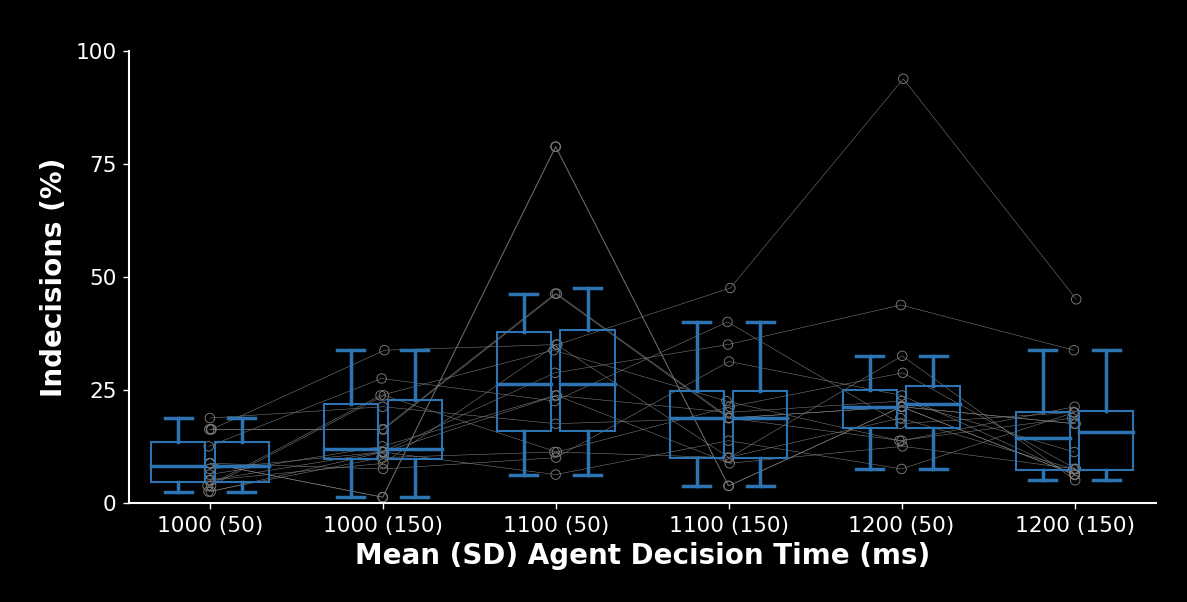

In [150]:
metric = group.combine_all_subjects('player_perc_indecisions') 
sim_metric = perc(player_indecisions)

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs-bw/1.7,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)
multi_boxplot(ax,sim_metric,xlocs=xlocs+bw/1.7,box_width = bw,colors = wheel.seth_blue)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Indecisions (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'indecisions', dpi = 400, transparent = True)
plt.show()

### Wins

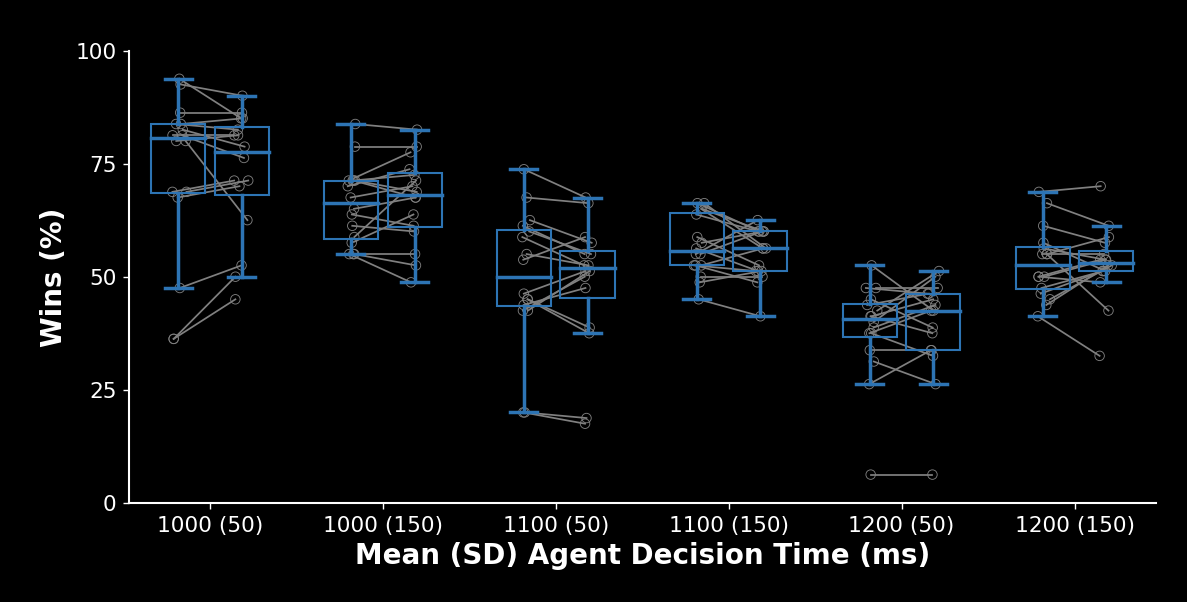

In [159]:
metric = group.combine_all_subjects('player_perc_wins') 
sim_metric = perc(player_wins)

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs-bw/1.7,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,sim_metric,xlocs=xlocs+bw/1.7,box_width = bw,colors = wheel.seth_blue)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],sim_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Wins (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'wins', dpi = 400, transparent = True)
plt.show()

Incorrects

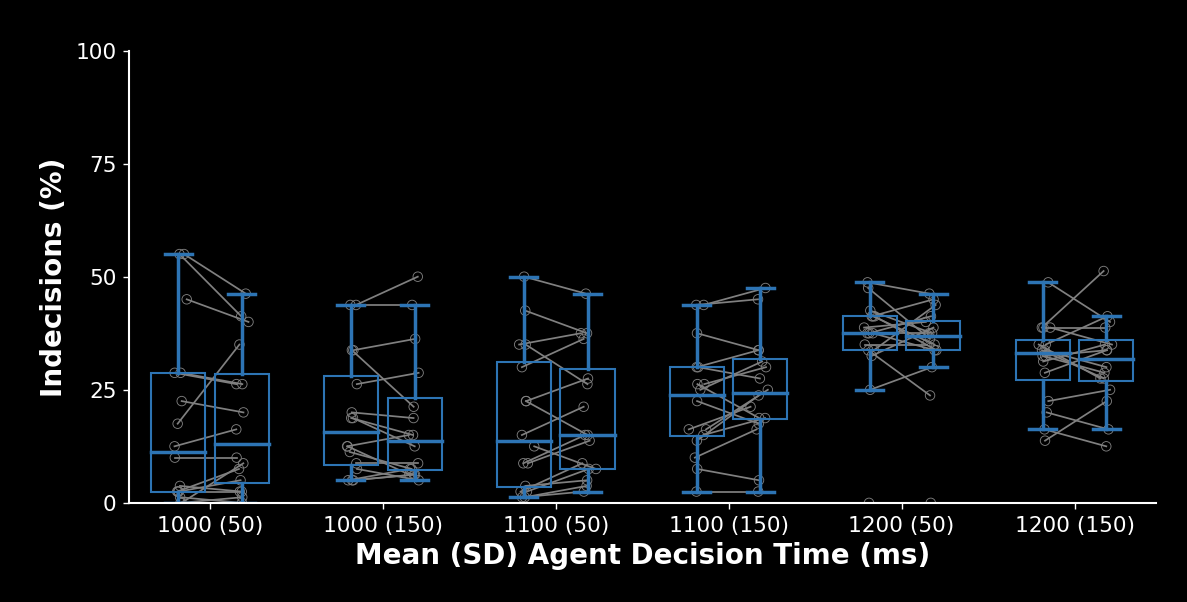

In [158]:
metric = group.combine_all_subjects('player_perc_incorrects') 
sim_metric = perc(player_incorrects)

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs-bw/1.7,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,sim_metric,xlocs=xlocs+bw/1.7,box_width = bw,colors = wheel.seth_blue)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],sim_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Incorrects (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects', dpi = 400, transparent = True)
plt.show()

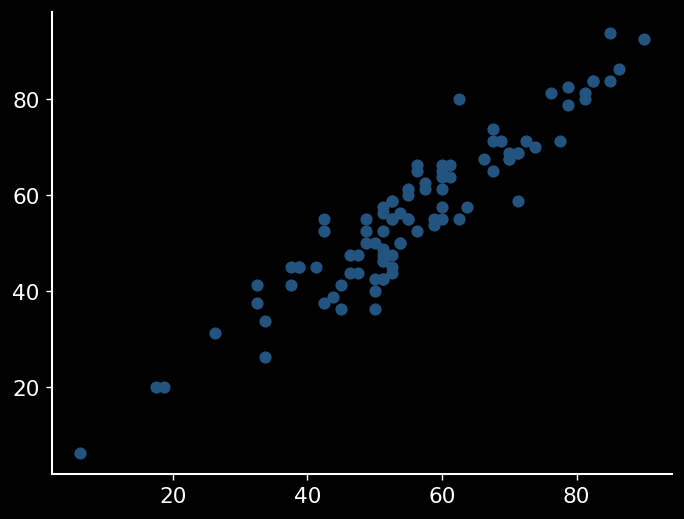

In [155]:
fig,ax = plt.subplots()
ax.scatter(sim_metric,metric)

In [ ]:
prob_indecision

array([[0.07549917, 0.00828205, 0.617408  , 0.05305271, 0.16740155,
        0.04093676],
       [0.22841922, 0.19426183, 0.45375907, 0.23146542, 0.26792032,
        0.1509474 ],
       [0.23013827, 0.06221413, 0.30015807, 0.19947917, 0.27148944,
        0.09436019],
       [0.09657631, 0.1358182 , 0.12615682, 0.1996285 , 0.08889025,
        0.23423879],
       [0.03684671, 0.07894156, 0.25903245, 0.18549585, 0.21321932,
        0.17022447],
       [0.08193052, 0.06558659, 0.08327033, 0.32120724, 0.17518745,
        0.06487066],
       [0.43406866, 0.2860039 , 0.39473578, 0.46684791, 0.83783453,
        0.52189872],
       [0.04021117, 0.07717201, 0.21653219, 0.04144449, 0.1166691 ,
        0.04888584],
       [0.02661479, 0.07867081, 0.33557309, 0.29643095, 0.40249793,
        0.34295356],
       [0.10737897, 0.25692898, 0.36276949, 0.20499362, 0.10412278,
        0.17897561],
       [0.13809426, 0.25772812, 0.1008761 , 0.21435113, 0.27502206,
        0.0945546 ],
       [0.11093307, 0